# Distributed processing of JUNO datasets for improved energy reconstruction

## Group : *Città Romanze*

### Members

- Pietro Cappelli
    - e-mail: pietro.cappelli@studenti.unipd.it
    - ID: 2058332
- Alberto Coppi
    - e-mail: alberto.coppi@studenti.unipd.it
    - ID: 2053063
- Giacomo Franceschetto
    - e-mail: giacomo.franceschetto@studenti.unipd.it
    - ID: 2053348
- Nicolò Lai
    - e-mail: nicolo.lai@studenti.unipd.it
    - ID: 2064377 
    
### Author contribution statement

Each and every member of the group equally worked on the assigned project and the drafting of this notebook.

## Introduction

The Jiangmen Underground Neutrino Observatory (JUNO) is an experiment designed to study neutrino oscillations. The ability to accurately reconstruct particle interaction events in JUNO is of great importance for the success of the experiment. 

Several machine learning approaches have been applied to the vertex and the energy reconstruction, achieving the necessary level of accuracy for reaching the physical goal of JUNO. 

However, due to the experiment geometry, data needs to be significantly preprocessed before feeding machine learning models with it. Precisely, the spherical distribution of photomultipliers (PMTs) needs to be transformed into a 2-dimensional image. The currently adopted approach is a projection method that follows three guidelines:

1. A single PMT occupies a single pixel in the image to minimize the information loss.
2. The final image has a similar PMTs arrangement to the original distribution in the detector.
3. The total amount of pixels in the image is the minimum number that satisfies the first requirement.

There are about $17600$ PMTs in the central detector of JUNO. To avoid overlap of PMTs, these are arranged layer by layer from the top of the detector into the image's pixel so that PMTs with the same latitude will be arranged in the same row.

The optimal image size that ensures that no PMTs are overlapped is $230 \times 124$. An example of event on the sphere and its projection into an image is shown in the figure below.

<div class="container" style="display: inline-block;">  
  <figure>
  <div style="float: left; padding: 10px;">
    <img src='figures/ev_id_12_3d_.png' width="450" height="350" align="center"/>
    <figcaption align="center"><b><br>Fig. 1: Collected charge - 3D representation</b></figcaption>
  </div>
  <div style="float: right; padding: 10px;">
    <img src='figures/ev_id_12_2d_.png' width="550" height="350" align="center"/>
    <figcaption align="center"><b><br>Fig. 2: Collected charge - 2D projection</b></figcaption>
  </div>
  </figure>
</div>

One of the few projection pitfalls is the high probability of having an event right where the latitude rings are opened and unrolled onto the image, as shown in the following example.

<div class="container" style="display: inline-block;">  
  <figure>
  <div style="float: left; padding: 10px;">
    <img src='figures/ev_id_16_3d_.png' width="450" height="350" align="center"/>
    <figcaption align="center"><b><br>Fig. 3: Collected charge - 3D representation</b></figcaption>
  </div>
  <div style="float: right; padding: 10px;">
    <img src='figures/ev_id_16_2d_.png' width="550" height="350" align="center"/>
    <figcaption align="center"><b><br>Fig. 4: Collected charge - 2D projection</b></figcaption>
  </div>
  </figure>
</div>

We believe that the occurrence of these events, that do not lead to a clear distributions of the measured observables, affects the training and prediction process of machine learning models. Therefore, the energy and vertex reconstruction accuracy could technically be improved if these events do not occur at all, and the machine learning model is fed with only clear images.

However, being the probability of neutrino interactions ideally uniform inside the detector, the occurrence of events which lead to a splitted distribution after the projection is non-negligible. Therefore, discarding these kind of events would lead to an overall loss of information. 

We here propose a novel preprocessing technique to eliminate dangerous events without being forced to ignore them, but instead turn them into clear images containing well-distributed information.



## Method

### Rotation and Mapping

We want to feed machine learning models with 2D images where the the center of charge is in the middle of it and not splitted by the 2D-mapping process. Hence, we rotate the original sphere to prepare it for the 2D-mapping process. We operate a *Rotation* in spherical coordinates along the $y$ and $z$ axis in this particular order. To evaluate the rotation angles ($\theta_R$ and $\varphi_R$) we first compute the charge center in cartesian coordinates. Namely, the sum of PMT positions weighted by the collected charge as follows:

$$
\begin{aligned}
x_c = \frac{\sum_i x_i \cdot c_i }{\sum_i c_i} \, ; &&&
y_c = \frac{\sum_i y_i \cdot c_i }{\sum_i c_i} \, ; &&
z_c = \frac{\sum_i z_i \cdot c_i }{\sum_i c_i}.
\end{aligned}
$$

From cartesian coordinates we switch to spherical coordinates:

$$
\begin{cases}
\theta_C = \arctan  \sqrt{\frac{x_c^2 + y_c^2}{z_c}} \\
\varphi_C = \arctan (\frac{y}{x})
\end{cases}
$$

These angles describe the vector $\vec{r_c}\,(\theta_c,\,\varphi_c)$ that points to the charge center. 

We then want to rotate the sphere to have the charge center in the "origin" of the spherical coordinates system. The rotation angles will thus be $\varphi_R = - \varphi_c$ and $\theta_R=-\theta_c + \frac{\pi}{2}$.

Finally the new, rotated, cartesian PMT coordinates are computed through the following matrix multiplication:

$$
\begin{bmatrix}
x'\\
y'\\
z'
\end{bmatrix}
=
R_{yz}
\times
\begin{bmatrix}
x\\
y\\
z
\end{bmatrix}
$$

where the rotation matrix is:

$$
{\displaystyle R_{yz}(\theta, \varphi)={\begin{pmatrix}\cos \varphi \cos \theta &\sin \theta \cos \theta &\sin \theta \\
\sin \varphi &\cos \varphi & 0 \\
-\sin \theta \cos \varphi  &\sin \varphi \sin \theta & \cos \theta \end{pmatrix}}.}
$$

Once the 3-dimensional sphere is rotated and the charge center aligned with the origin, the *Mapping* procedure (i.e. the projection of the sphere onto the 2-dimensional image) can be performed by recycling the mapping procedure known in the literature with just a couple of tweaks in the code. 

The final $230 \times 124$ images will thus have the center of charge right in the middle. 

To reduce empty spaces at the images corners, we could also perform a cut selecting only the region around the center of charge. Though, this technique will not be covered in this notebook.


## Implementation

In [1]:
import sys
import dask
import glob

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import dask.dataframe    as dd
import dask.bag          as db

from dask.distributed import Client, SSHCluster, get_task_stream, performance_report
from time import time, sleep
from tqdm import tqdm
from bokeh.io import export_png
from IPython.display import display, HTML

### Resources and Cluster

We have 5 virtual machines available on CloudVeneto, all sharing the following specifications:

* VCPUs &rarr; 4
* RAM &rarr; 8 GB
* STORAGE &rarr; 25 GB

Our datasets are stored in a separate volume of 5 TB capacity, attached to one of the five virtual machines that we will refer to as VM1 in the following. To make the datasets avaiable to all five machines, we have shared the volume through a network file system (NFS) using VM1 as NFS server and having the other four acting as NFS clients. 

On top of that, we created a Dask cluster where VM1 hosts the scheduler and the other four virtual machines are employed for spawning worker processes. 

This way, VM1 acts as NFS server and Dask scheduler and it is not employed in computations. Instead VM2 to VM5 are only exploited for computations. Since we are not dealing with extremely demanding tasks, it could have been possible to use VM1 for computations too. 

In [ ]:
# number of workers to spawn in each VM (VMs 2 to 5)
n_workers_vm = 4

# number of threads per worker
n_threads_wk = 1

# total number of workers is 4 virtual machines times the number of workers per machine
n_workers    = 4 * n_workers_vm

cluster = SSHCluster(
    ["10.67.22.39", "10.67.22.74", "10.67.22.27", "10.67.22.91", "10.67.22.60"],
    connect_options   = {"known_hosts": "/root/.ssh/known_hosts"},
    worker_options    = {"nthreads": n_threads_wk, "n_workers": n_workers_vm},
    scheduler_options = {"dashboard_address": ":8787"}
)

In [17]:
client = Client(cluster)
client

<Client: 'tcp://10.67.22.39:34575' processes=4 threads=4, memory=7.77 GiB>

### Load Mapping Data

With "mapping data" we refer to all pieces of information that are necessay to map our datasets into a 2-dimensional image, such as PMT coordinates on the sphere.

In [9]:
# path to data
data_folder       = "/root/data/data/real/train/data/"

# mapping data file names
pmt_pos_fname     = "PMTPos_CD_LPMT.csv"
pmt_id_conv_fname = "PMT_ID_conversion.csv"

# data file name for one-file tests
train_data_fname  = "raw_data_train_4.npz"

# data file names for multiple-file tests
nfiles = 20
name_list = glob.glob('*.npz', root_dir=data_folder)[:nfiles]

In [10]:
# load mapping data into pandas.DataFrame
pmt_positions  = pd.read_csv(pmt_pos_fname)
conversion_ids = pd.read_csv(pmt_id_conv_fname)

### Distributed processing


Our goal is to parallelize the process of the Rotation and Mapping of the events. Our approach is to process one file at time, which contain a variable number of events, by processing the single events. First of all we load one file in a `dask.bag` and split it across all the workers. This means that one worker will have a certain number of events according the number of workers and to the number of partitions of the Bag. 
Then, we build two function which Rotate and Map one single event: `rotate_ev()`, `mapping_single_events()`. 
Our idea is to parallelize this two function in order to have each worker processing their events at the same time, through a db.map() method in Dask. First we *map* the Rotate function on the Bag with the events per worker, and then we *map* the Mapping function on the Bag with the rotated results. Recall that each operation on the Bags in Dask "Lazy" which means that the intermediate results are the *promise* of it. The workers start effectively to calculate the results when we call the compute method of the Bag with the mapped results: `mapped.compute()`.

For each process we also print the execution time to highlights the lazy, the eager and the compute differences.

#### Functions

In [2]:
def load(path):
    return np.load(path, allow_pickle=True)["a"]

def R_yz(theta_rot, phi_rot):
    return np.array([[np.cos(phi_rot) * np.cos(theta_rot), -np.sin(phi_rot) * np.cos(theta_rot), np.sin(theta_rot)], 
                     [np.sin(phi_rot), np.cos(phi_rot), 0], 
                     [-np.sin(theta_rot) * np.cos(phi_rot), np.sin(theta_rot) * np.sin(phi_rot), np.cos(theta_rot)]])

def convert_pmt_ids(input_ids, conversion_ids):
    cd_ids  = np.array(conversion_ids["CdID"])
    pmt_ids = np.array(conversion_ids["PMTID"])
    mask    = np.isin(cd_ids, input_ids)
    return pmt_ids[mask]

def find_pmt_coord(pmt_positions, data_pmt_id):
    return pmt_positions[
        np.isin(pmt_positions.PMTID, data_pmt_id)
        ].loc[:, ['x', 'y', 'z']].reset_index(drop=True).to_numpy()

In [3]:
def load_bag(path, Nevents):
    data_np = load(path)
    data_np = data_np[:, :Nevents]
    return [np.vstack([ data_np[j, i] for j in range(3)]) for i in range(data_np.shape[1])]

#### Rotation

In [4]:
def rotate_ev(data):

    nonzeros_inds = data[2] != 0.0
    data_pmt_id   = convert_pmt_ids(data[0][nonzeros_inds], conversion_ids)
    pmt_coord     = find_pmt_coord(pmt_positions, data_pmt_id)

    tot_charge = sum(data[1][nonzeros_inds])
    x_cc       = sum(pmt_coord[:,0] * data[1][nonzeros_inds]) / tot_charge
    y_cc       = sum(pmt_coord[:,1] * data[1][nonzeros_inds]) / tot_charge
    z_cc       = sum(pmt_coord[:,2] * data[1][nonzeros_inds]) / tot_charge

    theta_cc   = np.arctan2(
        np.sqrt((x_cc)**2+(y_cc)**2), z_cc
    )
    phi_cc     = np.arctan2(y_cc, x_cc) 

    theta_rot = -theta_cc + np.pi/2
    phi_rot   = -phi_cc
    
    # coord_new = np.matmul(R_yz(theta_rot, phi_rot), pmt_coord.T)
    coord_new = np.matmul(
        R_yz(theta_rot, phi_rot), pmt_coord.T
    )

    R = np.sqrt(np.sum(np.power(coord_new, 2), axis=0))

    charge_hitt = np.vstack([data[1], data[2]])
    charge_hitt = charge_hitt[:,nonzeros_inds]

    rotated = np.vstack([coord_new, R, charge_hitt])
    
    del coord_new
    del charge_hitt
    del pmt_coord
    del data_pmt_id
    del nonzeros_inds
    
    return rotated

#### Mapping

In [5]:
N_max = 115

def mapping_single_event(rotated_ev):
    ####################
    # rotated_ev must be computed
    ####################
    coord_new   = rotated_ev[:3]
    charge_hitt = rotated_ev[4:, ].T
    R           = rotated_ev[3, ].mean()
    del rotated_ev

    z_levels, step = np.linspace(coord_new[2,].min(), coord_new[2,].max(), 124, retstep=True)
    image_mat      = np.zeros((230,124,2))

    for j, z in enumerate(z_levels):
        mask = (np.abs(coord_new[2,] - z) < step/2)         
        if(not np.any(mask)): continue
        masked = coord_new[:,mask]

        Rz = (R**2 - z**2)
        Neff = 0 if Rz < 0 else N_max * np.sqrt(Rz) / R
        ix = np.around( Neff * (np.arctan2(masked[1,], masked[0,]) / np.pi) + (N_max / 2) ) + 57
        ix = ix.astype(np.int32)
        if(np.any(ix >= 230)):
            ix[ix >= 230] = ix[ix >= 230] - 230

        image_mat[ix, j,] = charge_hitt[mask, ]

        del ix
        del masked
        del mask
                
    del z_levels
    del coord_new
    del charge_hitt
    
    return image_mat

#### Run rotation and mapping

In [10]:
Nevents = None

# Loading data into a Dask Bag, eagerly
start = time()
data_db = db.from_sequence(load_bag(data_folder + train_data_fname, Nevents=None), npartitions=16)
stop = time()

print('Execution time:', stop-start)
data_db

Execution time: 15.74086308479309


dask.bag<from_sequence, npartitions=16>

Execution time: 0.027271747589111328


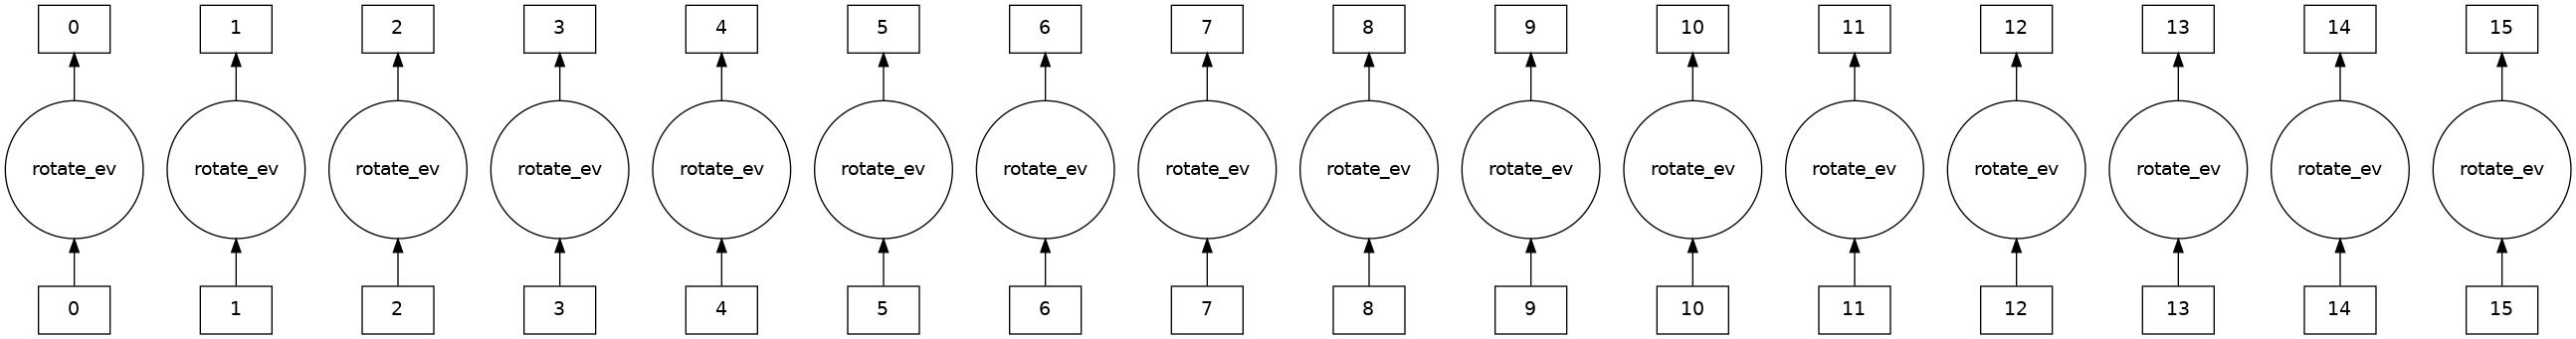

In [11]:
# Distribute the Rotation Process
start = time()
rotated = db.map(rotate_ev, data_db)
stop = time()

print('Execution time:', stop-start)

rotated.visualize()

#### Visualize one rotated event

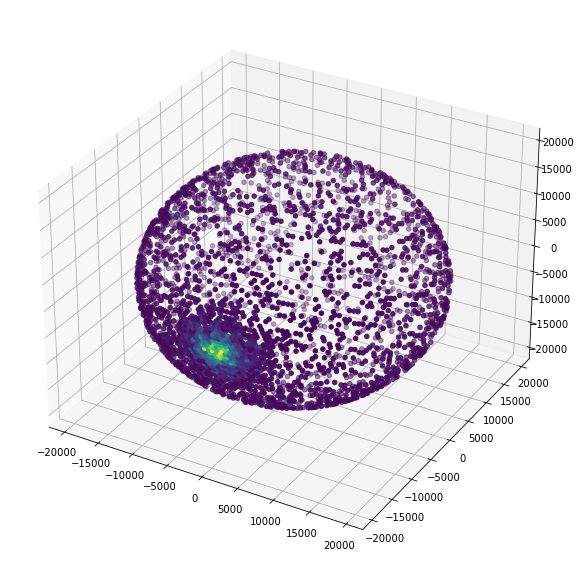

In [12]:
ev = 4
rot = rotated.take(ev+1)[ev]

fig = plt.figure(figsize=(10,12))
axr = fig.add_subplot(111, projection='3d')

axr.scatter(
    xs = rot[1, :],
    ys = -rot[0, :],
    zs = rot[2, :],
    c  = rot[4, :]
    )

Execution time: 0.001920461654663086


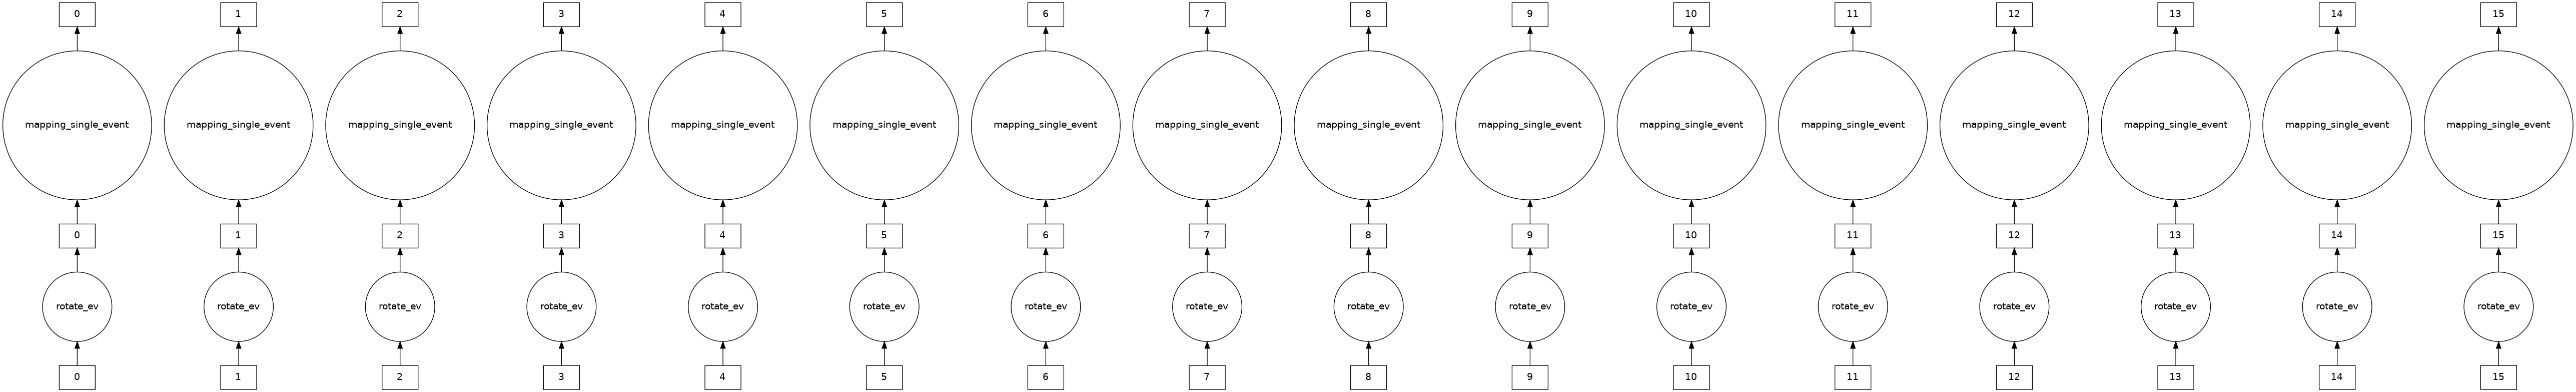

In [13]:
# Distribute the Mapping Process
 
start = time()
mapped = db.map(mapping_single_event, rotated)
stop = time()

print('Execution time:', stop-start)
mapped.visualize()

In [14]:
# Compute
with performance_report(filename='reports/dask-report_1file.html'):
    start = time()
    images = mapped.compute(optimize_graph=False)
    stop = time()

print('Execution time:', stop-start)

Execution time: 19.709824323654175


In [17]:
# display the report
display(HTML(filename='reports/dask-report_1file.html'))

#### Visualize the mapped event

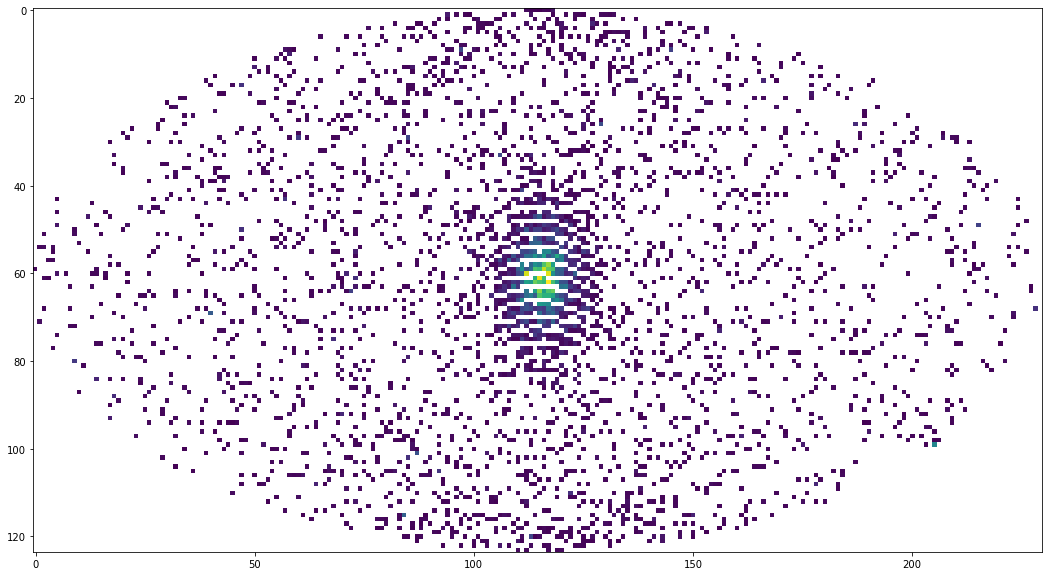

In [20]:
ev = 4

image = images[ev][:,:,0].T
image[image == 0] = np.NaN

fig, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(image)
plt.show()

## Benchmarks

Using the previous code, we have benchmarked the algorithm performance varying three key parameters:

1. The number of workers per virtual machine
2. The number of threads per worker
3. The number of partitions of the Dask bag holding our dataset

The python code we have written to explore this parameter space can be found in the `benchmark.py` file. Anyway, it is simply a for loop over some values for the parameters. 

We have chosen to test the time performance on 1024 events.

### Heatmaps

We could only test two parameters at the same time, not three, due to workers RAM overload. Thus, we first explored `n_workers` versus `n_threads` keeping the number of partitions fixed to 16. 

| | Workers versus Threads - Partitions fixed to 16 | |
|:-------------------------------------:|:-------------------------------------------:|:-----------------------------------------:|
![](figures/heatmaps/load_time_wt.png)  |  ![](figures/heatmaps/compute_time_wt.png)  |  ![](figures/heatmaps/total_time_wt.png)

Then, we tested `n_workers` versus `n_partitions` keeping the number of threads fixed to 1 thread per worker.

| | Workers versus Partitions - Threads fixed to 1 | |
|:-------------------------------------:|:-------------------------------------------:|:-----------------------------------------:|
![](figures/heatmaps/load_time_wp.png)  |  ![](figures/heatmaps/compute_time_wp.png)  |  ![](figures/heatmaps/total_time_wp.png)

Finally, to verify that the two configurations

* 1 worker per VM with 4 threads
* 4 workers per VM with 1 thread each

are time-performance equivalent, we also tested these configurations with the appropriate number of partitions, namely 4 in the former configuration and 16 in the latter. Thus, we explored the time performance varying the number of workers per VM and the number of threads per worker, setting the number of partitions to the total number of workers (i.e. 4 times the number of workers per VM).

| | Workers versus Threads - Partitions equal to the total number of workers | |
|:--------------------------------------:|:--------------------------------------------:|:------------------------------------------:|
![](figures/heatmaps/load_time_wtp.png)  |  ![](figures/heatmaps/compute_time_wtp.png)  |  ![](figures/heatmaps/total_time_wtp.png)

The results are not quite what we were expecting, as it is still present a sensible difference between the two time performance. Our first attempt at explaining why the two configurations, that should exploit the total number of VCPUs available, do not perform equally is based on the fact that Dask bags are not optimized for multi-threading if operations are pure Python functions.

### Workers versus Threads trends

#### Load time

| Workers versus Threads - Partitions fixed to 16 | Workers versus Threads - Partitions equal to the total number of workers | 
|:-------------------------------------:|:-------------------------------------------:|
![](figures/trends/load_time_wt_wtrend.png)  |  ![](figures/trends/load_time_wtp_wtrend.png)  
![](figures/trends/load_time_wt_ttrend.png)  |  ![](figures/trends/load_time_wtp_ttrend.png) 

#### Compute time

| Workers versus Threads - Partitions fixed to 16 | Workers versus Threads - Partitions equal to the total number of workers | 
|:-------------------------------------:|:-------------------------------------------:|
![](figures/trends/compute_time_wt_wtrend.png)  |  ![](figures/trends/compute_time_wtp_wtrend.png)  
![](figures/trends/compute_time_wt_ttrend.png)  |  ![](figures/trends/compute_time_wtp_ttrend.png) 

#### Total time

| Workers versus Threads - Partitions fixed to 16 | Workers versus Threads - Partitions equal to the total number of workers | 
|:-------------------------------------:|:-------------------------------------------:|
![](figures/trends/total_time_wt_wtrend.png)  |  ![](figures/trends/total_time_wtp_wtrend.png)  
![](figures/trends/total_time_wt_ttrend.png)  |  ![](figures/trends/total_time_wtp_ttrend.png) 


### Workers versus Partitions trends (threads fixed to 1 per worker)

#### Load time

| Workers trend | Partitions trend | 
|:-------------------------------------:|:-------------------------------------------:|
![](figures/trends/load_time_wp_wtrend.png)  |  ![](figures/trends/load_time_wp_ptrend.png)

#### Compute time

| Workers trend | Partitions trend | 
|:-------------------------------------:|:-------------------------------------------:|
![](figures/trends/compute_time_wp_wtrend.png)  |  ![](figures/trends/compute_time_wp_ptrend.png)


#### Total time

| Workers trend | Partitions trend | 
|:-------------------------------------:|:-------------------------------------------:|
![](figures/trends/total_time_wp_wtrend.png)  |  ![](figures/trends/total_time_wp_ptrend.png)


## Compute large amount of files
Once the implementation has been tested over one file to study performances on various combinations of cluster parameter we studied how to run the computation over multiple files.  
In fact, the dataset is composed by 1002 raw data training files in `.npz` format, each one containing 5000 simulated events. This means that roughly 700 MB of RAM are occupied to load each file.

To deal with these large data volumes we developed two types of implementations, **eager** and **lazy**.

### Eager implementation
This method assigns the Scheduler the job of reading the data file and partition and send the events to the Workers. A simple `for` loop over the files is enough.  
As soon as the Bag containing data is declared the Scheduler starts reading the file and once it has sent data to Workers its RAM is freed, so that it can load the next file once the Workers have finished their jobs.  

Particular care must be given to saving the results: as the images obtained from a single raw data file occupy almost 2.3 GB, retrieving them from Workers to the Scheduler is inefficient and can cause the RAM to fill up completely and the Python kernel to shut down.  
Thus, each Worker has to take care of saving its own images. This is achieved by exploiting `dask.bag.map_partitions()`, taking care of defining the right amount of partitions.

In [7]:
# Load data from .npz file, taking care of deleting useless variables
def load(path):
    file = np.load(path, allow_pickle=True)
    data = file['a']
    del file.f
    file.close()
    del file
    return data

# Given a partition, which is a list containing processed images, save it in a single .npy file
def save_partition(chunk, filename):
    array = np.stack(chunk)
    np.save(filename[0], array, allow_pickle=False)
    length = len(array)
    del array
    del chunk
    # the length of the saved array, which is the number of events, is returned for debug purposes
    return length

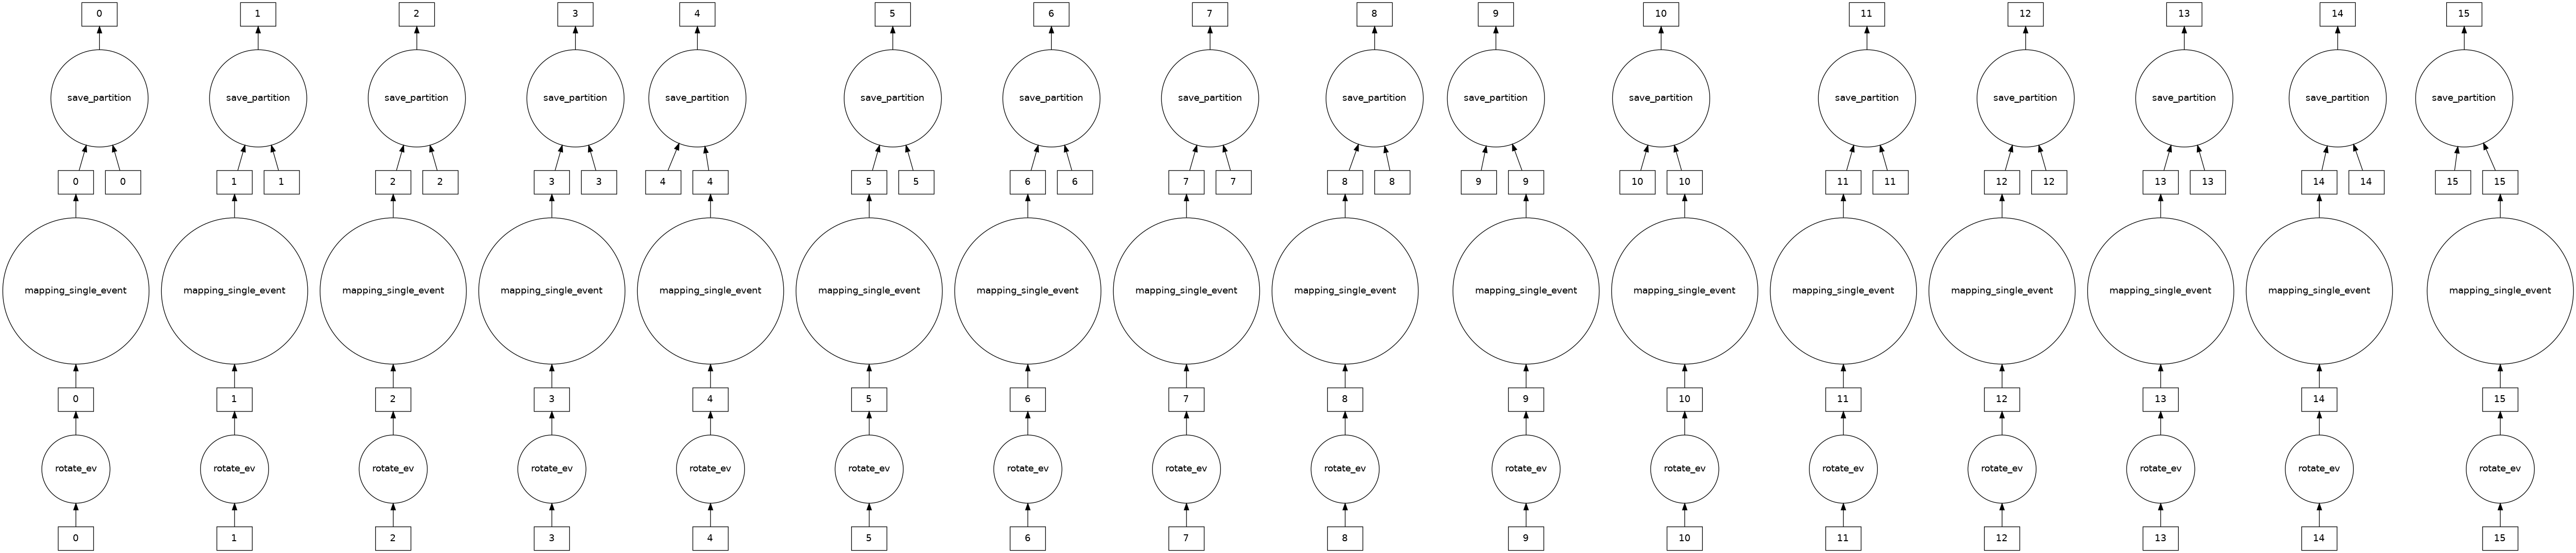

In [18]:
client.restart()

compute_times = []
load_times    = []

for j, file_name in enumerate(name_list):
  
    # load one file, this is done eagerly
    start   = time()
    data_db = db.from_sequence(load_bag(data_folder + file_name, Nevents=None), npartitions=n_workers)
    stop    = time()
    load_times.append(stop-start)
    
    # declare #npartitions processed file names for each raw data file
    ofilenames = db.from_sequence(['/root/data/test/proj_' + file_name.split('.')[0] + 
                                   '.part' + str(i) for i in range(n_workers)], npartitions=n_workers)

    # rotate the events, lazily
    rotated = db.map(rotate_ev, data_db)
    # mapping the events, lazily
    mapped = db.map(mapping_single_event, rotated)
    # save each partition to a single .npy file
    save = db.map_partitions(save_partition, mapped, ofilenames)
    
    # trigger the computation
    with performance_report(filename=f'reports/dask-report_files{j}.html'):
        start = time()
        save.compute()
        stop  = time()
    compute_times.append(stop-start)

    # free RAM: have to delete all futures
    del mapped
    del rotated
    del data_db
    del ofilenames

compute_times = np.asarray(compute_times)
load_times = np.asarray(load_times)
# visualize DAG
save.visualize()

In [19]:
print(f'Compute time per file\n\tMean:\t{compute_times.mean():.2f} s', 
      f'\n\tstd:\t{compute_times.std():.2f} s', '\n', sep='', end='\n')

print(f'Load time per file\n\tMean:\t{load_times.mean():.2f} s', 
      f'\n\tstd:\t{load_times.std():.2f} s', '\n', sep='', end='\n')

Compute time per file
	Mean:	16.50 s
	std:	1.01 s

Load time per file
	Mean:	13.86 s
	std:	0.93 s



In [20]:
# display a report
display(HTML(filename='reports/dask-report_files0.html'))

### Lazy implementation
As the loading time of one file is comparable to the processing time, we may want to reduce the former, in order to avoid idle time. Exploiting the NFS we want to assign to Workers the job of reading raw data files, aiming to load more than one file at the same time.  

This can be achieved using `dask.bag.from_delayed()` and `dask.delayed()`. In fact, if the data Bag is created on the basis of delayed objects, raw data files are read by Workers when the computation is triggered.  
Due to limitations in the resources available we cannot load and process more than 3 files at a time. Assuming to have more resources available and thus to be able to load and process 10 or more files at a time, the advantages of this method become evident.

In [ ]:
# close the previous cluster and spawn a new one with tuned parameters
client.shutdown()
client.close()
# number of workers to spawn in each VM (VMs 2 to 5)
n_workers_vm = 2

# number of threads per worker
n_threads_wk = 2

# total number of workers is 4 virtual machines times the number of workers per machine
n_workers    = 4 * n_workers_vm

cluster = SSHCluster(
    ["10.67.22.39", "10.67.22.74", "10.67.22.27", "10.67.22.91", "10.67.22.60"],
    connect_options   = {"known_hosts": "/root/.ssh/known_hosts"},
    worker_options    = {"nthreads": n_threads_wk, "n_workers": n_workers_vm},
    scheduler_options = {"dashboard_address": ":8787"}
)

client = Client(cluster)
client

In [22]:
# optimize load_bag function and make it lazy
def load_bag(path, Nevents):
    data_np = load(path)
    data_mask = data_np[:, :Nevents]
    bag = [np.vstack([ data_mask[j, i] for j in range(3)]) for i in range(data_mask.shape[1])]
    del data_mask
    del data_np
    return bag 
lazy_load_bag = dask.delayed(load_bag)

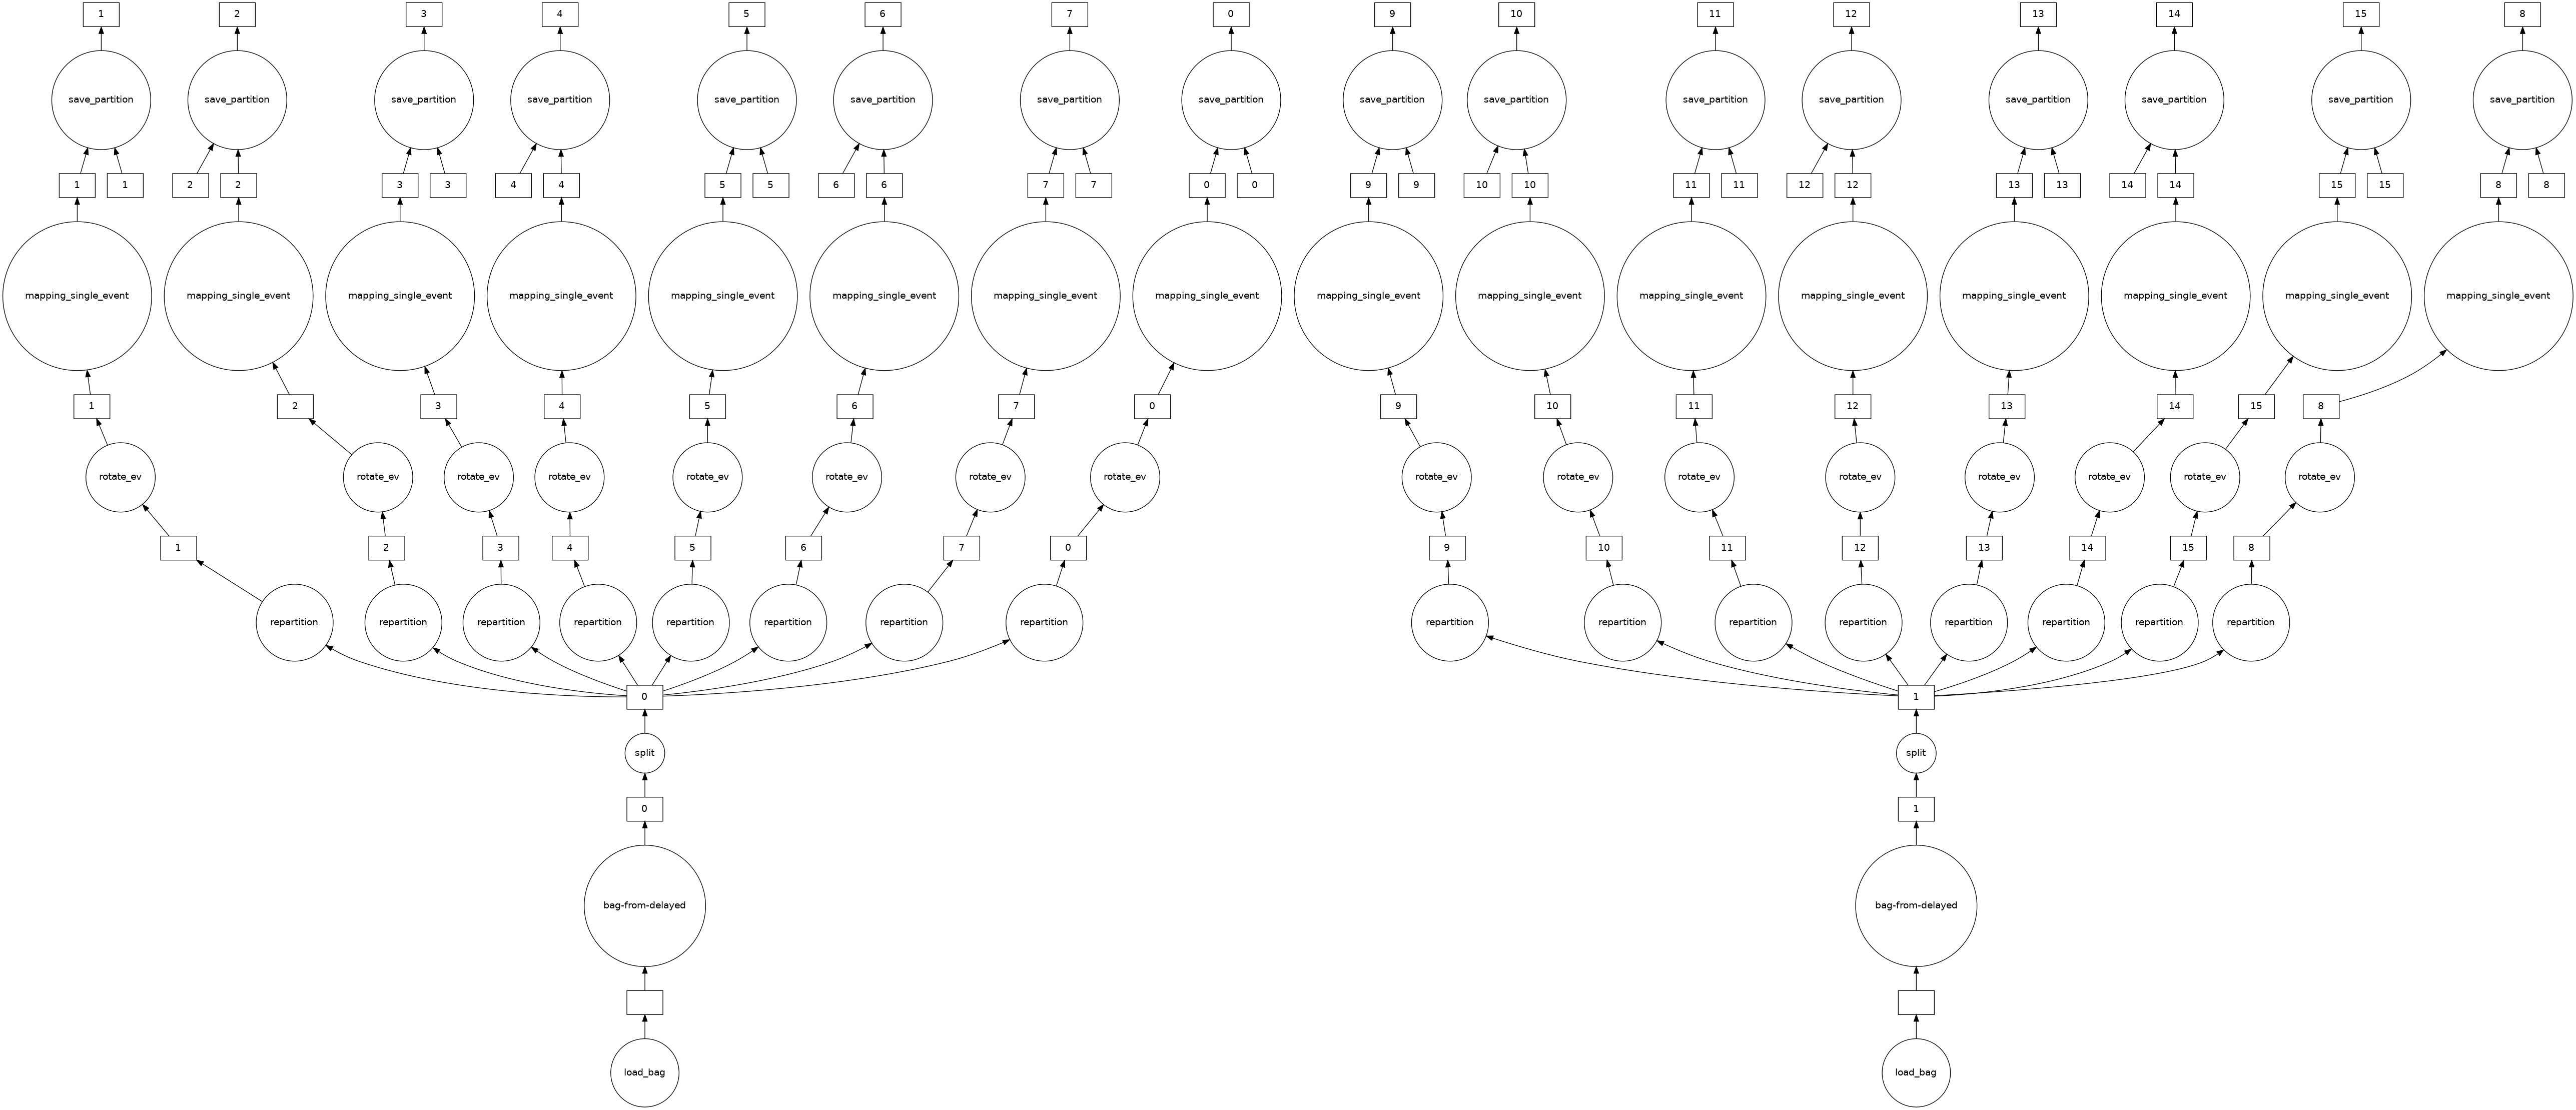

In [23]:
nfiles_cycle = 2
compute_times_lz = []
restart_times_lz = []
for i in range(0, nfiles, nfiles_cycle):
    
    # lazy loading of raw data files
    lazy_loaded = db.from_delayed([lazy_load_bag(data_folder + file_name, None) for file_name in name_list[i:i+nfiles_cycle]]).repartition(n_workers_vm*n_threads_wk*4)
    ofilenames = db.from_sequence(['/root/data/test/proj_' + name_list[k].split('.')[0] + '.part' + str(j) 
                                    for j in range(int(n_workers_vm*n_threads_wk*4/nfiles_cycle)) 
                                    for k in range(i, i+nfiles_cycle)])

    # process events, lazily
    rotated = db.map(rotate_ev, lazy_loaded)
    mapped = db.map(mapping_single_event, rotated)
    del rotated

    save = db.map_partitions(save_partition, mapped, ofilenames)     
    del mapped      
    del lazy_loaded
    del ofilenames
    
    # trigger asynchronous computation
    with performance_report(filename=f'reports/dask-report_fileslz{i}-{i+nfiles_cycle-1}.html'):
        start = time()
        future = client.compute(save, optimize_graph=False)
        result = client.gather(future)
        stop = time()
    compute_times_lz.append(stop-start)
    
    start = time()
    client.restart()
    stop = time()
    restart_times_lz.append(stop-start)

compute_times_lz = np.asarray(compute_times_lz)
restart_times_lz = np.asarray(restart_times_lz)

save.visualize(optimize_graph=False)

In [24]:
print(f'Compute times\n\tMean:\t{compute_times_lz.mean():.2f} s', 
      f'\n\tstd:\t{compute_times_lz.std():.2f} s', '\n', sep='', end='\n')

print(f'Restart times\n\tMean:\t{restart_times_lz.mean():.2f} s', 
      f'\n\tstd:\t{restart_times_lz.std():.2f} s', '\n', sep='', end='\n')

Compute times
	Mean:	71.57 s
	std:	3.09 s

Restart times
	Mean:	2.45 s
	std:	0.70 s



In [25]:
# display a report
display(HTML(filename='reports/dask-report_fileslz0-1.html'))

## Shutdown cluster

In [26]:
client.shutdown()

## Conclusions and future developments

### on the project

By exploiting distributed processing techniques we have successfully tackled our primary goal, namely building an algorithm that overcomes the issues of the original mapping procedure found in the literature. 

Due to the large size of our datasets, processing files in a distributed manner is most suited. However, we have easily reached the constraints put by the limited amount of resources available, especially when trying to have workers reading and processing different files independently at the same time. 

Having more than 1000 files containing 5000 events each, we estimate that with our current available resources we could process the whole dataset in around 10 hours. 

### on the bigger picture

After having processed the complete dataset, we may think of testing our machine learning model on the newly created images and see whether accuracy and training time improve, get worse or there is a tradeoff between the two. To further investigate this, we could also try to crop the new images around the center of charge to leave out the empty corners (i.e. low information regions) and drastically reduce the training time of our model. 